## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from torchvision import transforms, models
from torch.autograd import Variable

import os.path
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt

from fcts.load_data import load_data

from tqdm import tqdm_notebook as tqdm

from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.manifold import TSNE

## Configuration

In [2]:
# batch size
bs = 128
# subset for debugging
sub = False
# GPU or CPU
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

## Data

In [3]:
class IconDataset(Dataset):
    def __init__(self, part='train', transform=None, batch_size=128, sub_set=False):
        """
        :param part: get either train or test set; string
        :param transform: transformations, that should be applied on dataset
        :param batch_size: to have only batches of same size; int
        :param sub_set: subset of data; bool
        """
        self.data = load_data(part=part, batchsize=batch_size, subset=sub_set)
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        # transform image 
        if self.transform is not None:
            img_transformed = self.transform(img)
        # return transformed image
        return img_transformed

    def __len__(self):
        return self.data.shape[0]

In [4]:
# store mean and std of dataset; only for complete data
mean_icon = [183.09622661656687, 174.6211668631342, 171.76230690173531]
std_icon = [89.13559012807926, 85.83242306938422, 90.71514644175413]

In [5]:
# define transformations
normalize = transforms.Normalize(mean=mean_icon, std=std_icon)
trafo_train = transforms.Compose([transforms.ToTensor(), normalize])
trafo_test = transforms.Compose([transforms.ToTensor(), normalize])
# datasets
train_set = IconDataset(transform=trafo_train, sub_set=sub)
test_set = IconDataset(part='test', transform=trafo_test, sub_set=sub)
# dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=bs, shuffle=False)

In [6]:
print(len(train_set))

340352


##### Gray version of dataset and cropped to 28 x 28

In [7]:
# define transformations
trafo_train_gray = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.CenterCrop(size=28), transforms.ToTensor()])
trafo_test_gray = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.CenterCrop(size=28), transforms.ToTensor()])
# datasets
train_set_gray = IconDataset(transform=trafo_train_gray, sub_set=sub)
test_set_gray = IconDataset(part='test', transform=trafo_test_gray, sub_set=sub)
# dataloader
train_loader_gray = torch.utils.data.DataLoader(dataset=train_set_gray, batch_size=bs, shuffle=True)
test_loader_gray = torch.utils.data.DataLoader(dataset=test_set_gray, batch_size=bs, shuffle=False)

## Variational Autoencoder

### Baseline Architecture

#### Encoder

In [8]:
class Encoder_baseline(nn.Module):

    def __init__(self, layer_sizes, latent_dim, n_channels):
        super(Encoder_baseline, self).__init__()
        """
        :param layer_sizes: list of sizes of layers of the encoder; list[int]
        :param latent_dim: dimension of latent space, i.e. dimension out output of the encoder; int
        :param n_channels: number of channels of images; int
        """
        # store values
        self.latent_dim = latent_dim
        self.channels = n_channels
        
        # initialize layers
        layer_list = []
        for in_dim, out_dim in zip(layer_sizes, layer_sizes[1:]):
            layer_list.append(nn.Linear(in_dim, out_dim))
            layer_list.append(nn.ReLU())
        
        # store layers
        self.layers = nn.Sequential(*layer_list)
        
        # layers for latent space output
        self.out_mean = nn.Linear(layer_sizes[-1], latent_dim)
        self.out_var = nn.Linear(layer_sizes[-1], latent_dim)
    
    def forward(self, x):  
        """ 
        :param x: tensor 
        :return means: tensor of dimension 
        :return log_var: tensor of dimension 
        """
        
        # flatten x
        #print(x.size())
        #x = x.view(-1, self.channels, x.size(-1)**2)
        
        # forward 
        out = self.layers(x)
        
        # latent space output
        means = self.out_mean(out)
        log_vars = self.out_var(out)
     
        return means, log_vars
    

#### Decoder

In [9]:
class Decoder_baseline(nn.Module):

    def __init__(self, layer_sizes, latent_dim, n_channels):     
        super(Decoder_baseline, self).__init__()
        """
        :param layer_sizes: list of sizes of layers of the decoder; list[int]
        :param latent_dim: dimension of latent space, i.e. dimension of input of the decoder; int
        :param n_channels: number of channels of images; int
        """

        self.latent_dim = latent_dim
        self.channels = n_channels
        self.layer_sizes = layer_sizes
        
        layer_list = [nn.Linear(latent_dim, layer_sizes[0])]
        
        # initialize layers
        for in_dim, out_dim in zip(layer_sizes, layer_sizes[1:]):
            layer_list.append(nn.ReLU())
            layer_list.append(nn.Linear(in_dim, out_dim))

        # store layers
        self.layers = nn.Sequential(*layer_list)
            
    def forward(self, z):
        """
        :param z: tensor
        :return x: mu of gaussian distribution (reconstructed image from latent code z)
        """

        # forward
        h = int(np.sqrt(self.layer_sizes[-1]))
        x = torch.sigmoid(self.layers(z)).view(-1, self.channels, h, h)

        return x

#### Model

In [10]:
class VAE_baseline(nn.Module):

    def __init__(self, inp_dim, encoder_layer_sizes, decoder_layer_sizes, latent_dim, n_channels):
        """
        :param inp_dim: dimension of input; int
        :param encoder_layer_sizes: sizes of the encoder layers; list
        :param decoder_layer_sizes: sizes of the decoder layers; list
        :param latent_dim: dimension of latent space/bottleneck; int
        :param n_channels: number of channels of images; int
        """
        
        super(VAE_baseline, self).__init__()
        
        self.latent_dim = latent_dim
        self.channels = n_channels
        
        self.encoder = Encoder_baseline(encoder_layer_sizes, latent_dim, n_channels)
        self.decoder = Decoder_baseline(decoder_layer_sizes, latent_dim, n_channels)
        
        
    def forward(self, x):
        """ 
        :param x: tensor of dimension 
        :return recon_x: reconstructed x
        :return means: output of encoder
        :return log_var: output of encoder (logarithm of variance)
        """
        batch_size = x.size(0)

        x = x.view(-1, self.channels, x.size(-1)**2)
        means, log_vars = self.encoder(x)
        std = torch.exp(.5*log_vars)
        eps = torch.randn_like(std)
        z = means + eps*std
        recon_x = self.decoder(z)

        return recon_x, means, log_vars
        
    def sampling(self, n=2):
        """
        :param n: amount of samples (amount of elements in the latent space); int
        :return x_sampled: n randomly sampled elements of the output distribution
        """
        
        # draw samples p(z)~N(0,1)
        z = torch.randn((n, self.latent_dim))
        # generate
        x_sampled = self.decoder(z)

        return x_sampled

### Advanced Architecture

In [11]:
class VAE_advanced(nn.Module):
    def __init__(self, n_channels, height, batchsize):
        """
        :param n_channels: number of channels of images; int
        :param height: height of images, expected height = width; int
        """
        super(VAE_advanced, self).__init__()
        
        # store values
        self.channels = n_channels
        self.height = height

        # Encoder
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, height, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(height)
        self.conv3 = nn.Conv2d(height, height, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(height)
        self.conv4 = nn.Conv2d(height, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(8 * 8 * 16, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc21 = nn.Linear(512, 512)
        self.fc22 = nn.Linear(512, 512)

        # Decoder
        self.fc3 = nn.Linear(512, 512)
        self.fc_bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 8 * 8 * 16)
        self.fc_bn4 = nn.BatchNorm1d(8 * 8 * 16)

        self.conv5 = nn.ConvTranspose2d(16, height, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(height)
        self.conv6 = nn.ConvTranspose2d(height, height, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(height)
        self.conv7 = nn.ConvTranspose2d(height, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, n_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 8 * 8 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))

        return self.fc21(fc1), self.fc22(fc1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 8, 8)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, self.channels, self.height, self.height)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Loss

In [12]:
# Implement the loss function for the VAE
def vae_loss(recon_x, x, mu, log_var, loss_func=nn.MSELoss(reduction='mean')):
    """
    :param recon_x: reconstruced input
    :param x: input
    :param mu, log_var: parameters of posterior (distribution of z given x)
    :loss_func: loss function to compare input image and constructed image
    """

    recon_loss = loss_func(recon_x, x)
    kl_loss = torch.mean(0.5 * torch.sum(
        torch.exp(log_var) + mu**2 - 1. - log_var, 1))
    return recon_loss + kl_loss

In [21]:
# Implement the Loss function for the VAE/CVAE
def elbo(recon_x, x, mu, log_var):
    """
    :param recon_x: reconstruced input
    :param x: input,
    :param mu, log_var: parameters of posterior (distribution of z given x)
    :return neg_ELBO: neagtive ELBO
    """
    
    sigma_g = 1.
    
    neg_ELBO =0.5 * (torch.sum( mu.pow(2)+log_var.exp()-log_var-1 )+
                       torch.sum( (x-recon_x).pow(2)/sigma_g**2. ) )
    
    return neg_ELBO

### Test Function

In [14]:
def test(model, loader):
    """
    :param model: model to test
    :param loader: loader for test data
    """
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += vae_loss(recon_batch, data, mu, logvar).item()

    test_loss /= len(loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

### Training Function

In [18]:
# Training of the VAE
def train(model, epochs, path, optimizer, train_loader, test_loader):
    """
    :param model: model that will be trained; object
    :param epochs: number of epochs to train model; int
    :param path: path to store and load trained models; str
    :param optimizer: optimizer that is used for training
    :param train_/test_loader: dataloader for training and testing 
    """
    
    # check for previous trained models and resume from there if available
    try:
        previous = max(glob.glob(path + '/*.pth'))
        print('load previous model')
        checkpoint = torch.load(previous)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        loss = checkpoint['loss']
        epochs_trained = checkpoint['epoch']
    except Exception as e:
        print('no model to load')
        epochs_trained = 0
    
    model.train()
    
    for epoch in np.arange(epochs_trained, epochs): 
 
        train_loss = 0
        for batch_idx, data in enumerate(tqdm(train_loader, desc=f'Train Epoch {epoch}', leave=False)):
            x = data
            x = x.to(device)
            optimizer.zero_grad()

            recon_batch,  mu, log_var = model(x)
            #recon_batch = torch.ones(recon_batch.shape)
            
            loss = elbo(recon_batch,  x, mu, log_var)
            #loss = vae_loss(recon_batch, x, mu, log_var)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

        # save model
        torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, path+('/vae-{}.pth').format(f'00{epoch}'[-3:]))
        
        # test model
        test(model, test_loader)

## Experiments

### VAE Training

#### Grayscale Images: Baseline Architecture

In [32]:
# hyperparameters
encoder_layer_sizes_bl_gray = [28*28, 512, 256]
decoder_layer_sizes_bl_gray = [256, 512, 28*28]

latent_dim_baseline_bl_gray = 10 
vae_baseline_gray = VAE_baseline(inp_dim=(28*28), encoder_layer_sizes=encoder_layer_sizes_bl_gray, decoder_layer_sizes=decoder_layer_sizes_bl_gray, 
                                 latent_dim=latent_dim_baseline_bl_gray, n_channels=1)
vae_baseline_gray = vae_baseline_gray.to(device)
optimizer_baseline_gray = optim.Adam(vae_baseline_gray.parameters(), lr=1e-4)

epochs_baseline_gray = 15

In [ ]:
train(vae_baseline_gray, epochs_baseline_gray, './models/clustering/baseline/gray', optimizer_baseline_gray, train_loader_gray, test_loader_gray)

load previous model


====> Epoch: 10 Average loss: 22.3272
====> Test set loss: 0.0039


#### Colored Images: Baseline Architecture

In [ ]:
# hyperparameters
encoder_layer_sizes_bl_color = [32*32, 512, 256]
decoder_layer_sizes_bl_color = [256, 512, 32*32]

latent_dim_baseline_bl_color = 2 
vae_baseline_color = VAE_baseline(inp_dim=(32*32), encoder_layer_sizes=encoder_layer_sizes_bl_color, decoder_layer_sizes=decoder_layer_sizes_bl_color, 
                                 latent_dim=latent_dim_baseline_bl_color, n_channels=3)
vae_baseline_color = vae_baseline_color.to(device)
optimizer_baseline_color = optim.Adam(vae_baseline_color.parameters(), lr=1e-3)

epochs_baseline_color = 15

In [ ]:
train(vae_baseline_color, epochs_baseline_color, './models/clustering/baseline/color', optimizer_baseline_color, train_loader, test_loader)

#### Grayscale Images: Advanced Architecture

In [88]:
# hyperparameters
latent_dim_advanced_gray = 2 
vae_advanced_gray = VAE_advanced(n_channels=1, height=28, batchsize=bs)
vae_advanced_gray = vae_advanced_gray.to(device)
optimizer_advanced_gray = torch.optim.SGD(vae_advanced_gray.parameters(), lr=0.001, momentum=0.9)

epochs_advanced_gray = 15

In [89]:
train(vae_advanced_gray, epochs_advanced_gray, './models/clustering/advanced/gray', optimizer_advanced_gray, train_loader_gray, test_loader_gray)

no model to load


====> Epoch: 0 Average loss: 0.0694
====> Test set loss: 0.0189


====> Epoch: 1 Average loss: 0.0039
====> Test set loss: 0.0016


====> Epoch: 2 Average loss: 0.0013
====> Test set loss: 0.0011


====> Epoch: 3 Average loss: 0.0010
====> Test set loss: 0.0009


====> Epoch: 4 Average loss: 0.0009
====> Test set loss: 0.0009


====> Epoch: 5 Average loss: 0.0008
====> Test set loss: 0.0008


====> Epoch: 6 Average loss: 0.0008
====> Test set loss: 0.0008


====> Epoch: 7 Average loss: 0.0008
====> Test set loss: 0.0008


====> Epoch: 8 Average loss: 0.0008
====> Test set loss: 0.0008


====> Epoch: 9 Average loss: 0.0008
====> Test set loss: 0.0008


====> Epoch: 10 Average loss: 0.0008
====> Test set loss: 0.0008


====> Epoch: 11 Average loss: 0.0008
====> Test set loss: 0.0008


====> Epoch: 12 Average loss: 0.0008
====> Test set loss: 0.0008


====> Epoch: 13 Average loss: 0.0008
====> Test set loss: 0.0008


====> Epoch: 14 Average loss: 0.0008
====> Test set loss: 0.0008


In [90]:
test(vae_advanced_gray, test_loader_gray)

====> Test set loss: 0.0008


#### Colored Images: Advanced Architecture

In [91]:
# hyperparameters
latent_dim_advanced_color = 2 
vae_advanced_color = VAE_advanced(n_channels=3, height=32)
vae_advanced_color = vae_advanced_color.to(device)
optimizer_advanced_color = torch.optim.SGD(vae_advanced_color.parameters(), lr=0.001, momentum=0.9)

epochs_advanced_color = 15

TypeError: __init__() missing 1 required positional argument: 'batchsize'

In [ ]:
train(vae_advanced_color, epochs_advanced_color, './models/clustering/advanced/color', optimizer_advanced_color, train_loader, test_loader)

### Visualization

In [24]:
#path2model = max(glob.glob('./models/clustering/advanced' + '/*.pth'))
best_model = vae_baseline_gray
#best_model_dict = torch.load(path2model)
#best_model.load_state_dict(best_model_dict['model_state_dict'])

In [25]:
def imshow(inp):
    """Imshow for Tensor."""
    # unnomralize
    #inp = inp.mul(torch.FloatTensor(std_icon))#.add(torch.FloatTensor(mean)
    #inp = inp.numpy().transpose((1, 2, 0))
    inp = inp.numpy().squeeze()
    #inp = std_icon * inp + mean_icon
    #inp = np.clip(inp, 0, 1)
    #inp = (inp * 255).astype(np.uint8)
    plt.imshow(inp)

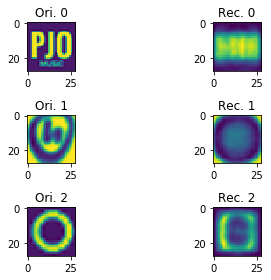

In [29]:
_, x= next(enumerate(train_loader_gray))
samples = x.to(device)

samples_rec,   _, _ = best_model(samples)
samples_rec = samples_rec.detach().cpu()

for i in range(0, 3):
    plt.subplot(3,2,2*i+1)
    plt.tight_layout()
    #imshow((samples[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
    imshow(samples[i])
    plt.title("Ori. {}".format(i))

    plt.subplot(3, 2, 2*i+2)
    plt.tight_layout()
    imshow(samples_rec[i])
    plt.title("Rec. {}".format(i))

TODO:
- use other architectures
- tune hyperparameters; latent space dimensions
- GPU

### ResNet Features

#### Pretrained Model

In [9]:
# load pretrained ResNet from Pytorch
resnet = models.resnet50(pretrained=True)

In [10]:
# get some sample images
samples = next(iter(train_loader))

In [11]:
# original output for 1000 ImageNet classes
resnet(samples).shape

torch.Size([128, 1000])

In [12]:
# drop last layer to get images represented by the last layer
modified_resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))

In [13]:
modified_resnet(samples).shape

torch.Size([128, 2048, 1, 1])

#### Encode Icons

In [14]:
def get_features(part='train'):
    """
    :param part: which part to get features of (train or test); string
    :return icon_features: ResNet features of icon dataset; list[np.array]
    """
    
    if part == 'train':
        loader = train_loader
    elif part == 'test':
        loader = test_loader
    else:
        print('Please provide part')
        return
        
    # get features
    icon_features = []
    for batch_idx, data in enumerate(tqdm(loader, desc='Encode {} set'.format(part), leave=False)):
        x = data
        x = x.to(device)
        features = np.squeeze(modified_resnet(x).detach().cpu().numpy())
        icon_features.append(features)
    
    return icon_features

In [15]:
# check if numpy array of already encoded icons exists and save; otherwise encode
features_path = '../data/features/resnet.npy'

if not os.path.isfile(features_path):
    # get features
    icon_features_train = get_features(part='train')
    icon_features_test = get_features(part='test')
    icon_features = icon_features_test + icon_features_train
    icon_features = np.concatenate(icon_features)
    # save features
    np.save(features_path, icon_features)
else:
    icon_features = np.load(features_path)

In [16]:
print(icon_features.shape)

(486377, 2048)


#### Dimensionality Reduction

##### PCA

In [16]:
# check if numpy array of already reduced features exists
features_reduced_path = '../data/features/pca.npy'

if not os.path.isfile(features_reduced_path):
    # get features
    reduced_icon_features = PCA(n_components=2).fit_transform(icon_features)
    # save features
    np.save(features_reduced_path, reduced_icon_features)
else:
    reduced_icon_features = np.load(features_reduced_path)

In [17]:
print(reduced_icon_features.shape)

(486377, 2)


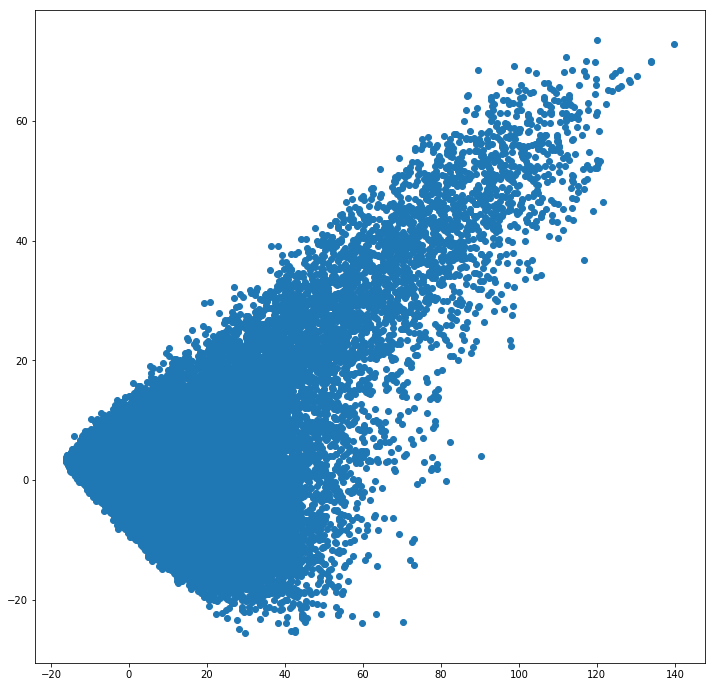

In [18]:
plt.figure(figsize=(12,12))
plt.scatter(x = reduced_icon_features[:, 0], y = reduced_icon_features[:, 1])

##### t-SNE

In [ ]:
# check if numpy array of already reduced features exists
features_embedded_path = '../data/features/tsne.npy'

if not os.path.isfile(features_embedded_path):
    print('pca')
    # beforehand reduce to lower dimension, due to computational complexity
    icon_features_50 = PCA(n_components=50).fit_transform(icon_features)  
    print('pca done')
    # get features
    embedded_icon_features = TSNE(n_components=2).fit_transform(icon_features_50)
    # save features
    np.save(features_embedded_path, embedded_icon_features)
else:
    embedded_icon_features = np.load(features_embedded_path)

pca
pca done


In [ ]:
print(embedded_icon_features.shape)

In [ ]:
plt.figure(figsize=(12,12))
plt.scatter(x = embedded_icon_features[:, 0], y = embedded_icon_features[:, 1])

In [20]:
two_means = cluster.MiniBatchKMeans(n_clusters=2)

In [21]:
two_means.fit(reduced_icon_features)

NameError: name 'reduced_icon_features' is not defined

In [108]:
y_pred = two_means.labels_.astype(np.int)

In [109]:
colors = np.array(['red', 'blue'])

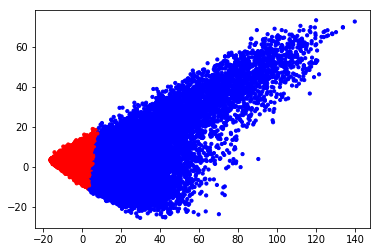

In [110]:
plt.scatter(x = reduced_icon_features[:, 0], y = reduced_icon_features[:, 1], s=10, color=colors[y_pred])

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(15,3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 2,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [(embedded_icon_features, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in tqdm(clustering_algorithms, desc=f'Clustering', leave=False):
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
            
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        #colors = ['red', 'blue', 'green']
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.savefig('./plots/clustering_tsne.png')
plt.show()

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
reduced_data = PCA(n_components=2).fit_transform(icon_features[:10000])
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

TODO:
- other network: Code: https://github.com/KaimingHe/deep-residual-networks (ResNet-50)